# <center>SM286D - Lesson 14 (Twitter Example) </center>
## <center>Capt Strickland</center>
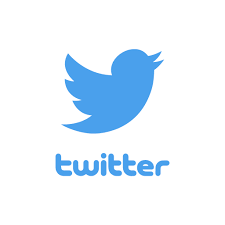

## Overview:
In this example we will analyze three popular restaurants/bars in downtown Annapolis: 
1. Armadillos Bar & Grill (*@DillosAnnapolis*)
2. Iron Rooster - Annapolis (*@AcmeBar*)
3. Acme Bar & Grill (*@ironroosterfood*)

Our goal is to pull data from Twitter's API, specifically targeting those who follow each of the above restaurants, construct a dataset of "connections", and build a network to identify how each of the restaurants is interacting with the population. 

### Import Statements
There are quite a few import states - most pertain to the construction of the network. We will utilize the bokeh package to display the network, more on visulatizations during week 13. More about bokeh can be found [here](https://docs.bokeh.org/en/latest/index.html).

In [1]:
import pandas as pd
import networkx
import matplotlib.pyplot as plt
import numpy as np
import json
import random
from bokeh.io import output_notebook, show, save
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.io import output_notebook, show, save
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis, Spectral, Viridis, Plasma, Category20c
from bokeh.transform import linear_cmap

output_notebook()

Loading BokehJS ...

### Data Download
Pulling data from the Twitter API is outside the scope of this class, so we have done it for you and uploaded the results into three json files: `dillosannapolis.json`, `AcmeBar.json`, and `ironroosterfood.json`. As you can see from the output below, the number of followers for each restaurant varies. Due to rate limits on the API, we can only pull so much data at one time - roughly 2500 followers every 15 minutes.

In [2]:
with open('dillosannapolis.json') as my_file:
    r1 = json.load(my_file)
print('Follower count for Armadillos:', len(r1))   

with open('AcmeBar.json') as my_file:
    r2 = json.load(my_file)
print('Follower count for Acme:', len(r2))  

with open('ironroosterfood.json') as my_file:
    r3 = json.load(my_file)
print('Follower count for Iron Rooster:', len(r3))  

Follower count for Armadillos: 911
Follower count for Acme: 603
Follower count for Iron Rooster: 2500


### Identifying Connections Among Followers
We need to create connection across all the users in our datasets. To complete this task we follows the below steps using the module `twitter_data_builder`:
1. We utilize the class `ConstructDictionary` to consolidate the json data for each restaurant into a dictionary for better handling. We keep key features such as the friends and follower count, any mentions, and build an initial connection between the username and the restaurant they follow. In addition, the class constructs a set of connections across users who follow the same restaurant. For example, if Bob and Beth follow Acme Bar & Grill, and Bob mentions Beth on Twitter, we assume a connection between Bob and Beth.
2. Next we utilize the Class `ConnectionsAcross`. This function builds connections across two restaurants. Looking again at whether a user mentions another user, the function will establish a connection between two users. For example, if Bob follows Acme Bar & Grill and Beth follows Iron Rooster, and Bob mentions Beth on Twitter, we assume a connection between Bob and Beth. 

#### Step 1:

In [3]:
from twitter_data_builder import ConstructDictionary

rest1 = ConstructDictionary(r1, 'dillosannapolis').rest_network
print('Follower count for Armadillos:', len(rest1))
rest2 = ConstructDictionary(r2, 'AcmeBar').rest_network
print('Follower count for Acme:', len(rest2))
rest3 = ConstructDictionary(r3, 'ironroosterfood').rest_network
print('Follower count for Iron Rooster:', len(rest3))

Follower count for Armadillos: 912
Follower count for Acme: 604
Follower count for Iron Rooster: 2501


#### Step 2

In [4]:
from twitter_data_builder import ConnectionsAcross

print("Restaurant 1, connections for follower 'glove':", "\n", 
      rest1['glove']['connections'], "\n")

print("Restaurant 2, connections data for follower 'glove':", "\n", 
      rest2['glove']['connections'], "\n")

restaurants = ConnectionsAcross(rest1,rest2).rest_across
print("Combining connections for 'glove' across restaurants 1 and 2 :",  "\n", 
      restaurants['glove']['connections'], "\n")

restaurants = ConnectionsAcross(restaurants,rest3).rest_across
print("Combining connections for 'glove' across restaurants 1&2 with restaurant 3 :",  "\n",
      restaurants['glove']['connections'], "\n")

print("All data we have on follower 'glove':", "\n", restaurants['glove'])

Restaurant 1, connections for follower 'glove': 
 [('glove', 'dillosannapolis')] 

Restaurant 2, connections data for follower 'glove': 
 [('glove', 'AcmeBar')] 

Combining connections for 'glove' across restaurants 1 and 2 : 
 [('glove', 'dillosannapolis'), ('glove', 'AcmeBar')] 

Combining connections for 'glove' across restaurants 1&2 with restaurant 3 : 
 [('glove', 'dillosannapolis'), ('glove', 'AcmeBar'), ('glove', 'ironroosterfood')] 

All data we have on follower 'glove': 
 {'location': 'Philly, PA!', 'friends_count': 36331, 'follower_count': 71633, 'description': 'On Tour! New album THE JUICE available now: https://t.co/rtq7t4kvrG We play Streetside Blues & are saving the world one show at a time❤️#bitcoin #NFT #ETH', 'mentions': ['morphine'], 'connections': [('glove', 'dillosannapolis'), ('glove', 'AcmeBar'), ('glove', 'ironroosterfood')]}


### Create New Data Structure
In order to plot our graph, we need to transition our restaurant data from a dictionary to a dataframe. A dataframe is like a table - think of Microsoft Excel. We utilize the pandas package, and create a table that consists of the two nodes in the connection along with friend and follower counts. The code for building the dataframe is located in the module `twitter_data_builder` using the class `BuildDf`

Because our network has over 3500 nodes, we limit the size of the network in order to display a more useful network. The nodes we choose to keep are those who are connected with a user with over 10,000 followers - giving us 127 connections to graph across 121 nodes.

In [5]:
from twitter_data_builder import BuildDf
df = BuildDf(restaurants, 10000).df
df.head()

,index,Node1,Node2,Friend_Count,Follower_Count
0,38,BretLaBelle,dillosannapolis,590,12993
1,70,KeithCRogers,dillosannapolis,11088,10420
2,143,DissensionR,dillosannapolis,34864,22234
3,377,DC_CarService,dillosannapolis,29216,11875
4,378,DC_CarService,ironroosterfood,29216,11875


### Create the Network Object
With our data cleaned, consolidated, and properly inside a data structure we will begin the process of constructing the network. 

In [6]:
#build network of nodes/arcs from dataframe created above
G = networkx.from_pandas_edgelist(df, 'Node1', 'Node2')

#Let's grab the degrees, degree centrality, closeness centrality, and betweeness centrality for the nodes in the network
degrees = dict(networkx.degree(G))
degree_centrality = dict(networkx.degree_centrality(G))
closeness_centrality = dict(networkx.closeness_centrality(G))
betweenness_centrality = dict(networkx.betweenness_centrality(G))

#set our network measurements above as attributes to our nodes
networkx.set_node_attributes(G, name='degree', values=degrees)
networkx.set_node_attributes(G, name='degree_centrality', values=degree_centrality)
networkx.set_node_attributes(G, name='closeness_centrality', values=closeness_centrality)
networkx.set_node_attributes(G, name='betweenness_centrality', values=betweenness_centrality)

#set the size of each node based on the node's degree value
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G)])
networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

#### Network Modularity
We have discussed serveral methods to measure "importance" inside a network. Another method of analyzing nodes in a network is through modularity. Modularity is the proces of identifying "families" or "communities" inside a network. The greedy modularity algorithm begins by assigning a node to it's own community, and joining other nodes to this community until the maximum modularity calculation is solved. 

The specifics of this algorithm are outside the scope of the class but more about modularity can be found [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html#networkx.algorithms.community.quality.modularity).


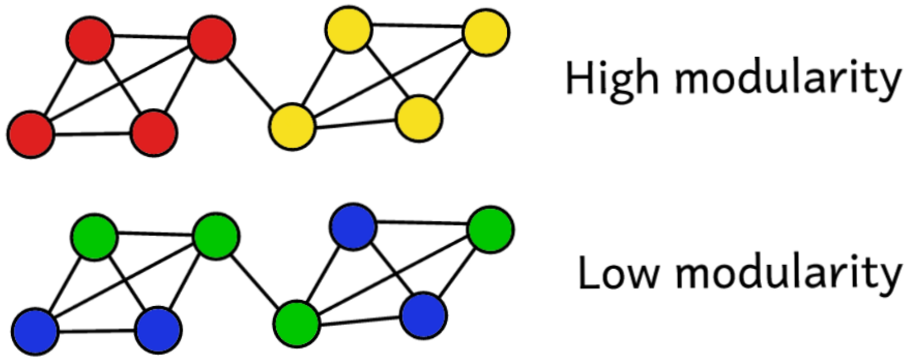


In [7]:
from networkx.algorithms import community #pro tip: community creates "frozensets" which are unchangeable sets
                                          #Because of this we need to re-import community each time we run this cell

#calculate modulariity 
communities = community.greedy_modularity_communities(G)

# Create empty dictionaries
modularity_class = {}
modularity_color = {}
friend_count = {}
follower_count = {}

#Loop through each community in the network
for community_number, community in enumerate(communities):
    #For each member of the community, add their community number and a distinct color, let's also grab the friend/follower counts too!
    for name in community: 
        modularity_class[name] = community_number
        friend_count[name] = restaurants[name]['friends_count']
        follower_count[name] = restaurants[name]['follower_count']      
        modularity_color[name] = Category20c[20][community_number]  
        
# Add modularity class and color as attributes from the network above
networkx.set_node_attributes(G, modularity_class, 'modularity_class')
networkx.set_node_attributes(G, modularity_color, 'modularity_color')
networkx.set_node_attributes(G, friend_count, 'friend_count')
networkx.set_node_attributes(G, follower_count, 'follower_count')

### Plot the Network
The following code constructs our network and we use the plotting package bokeh to help us draw the graphic. 

In [8]:
#random.seed(2021)
#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'modularity_color'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Category20c

#Choose a title!
title = 'Twitter Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Username", "@index"),
       ("Degree", "@degree"),
       ("Friends", "@friend_count"),
       ("Followers", "@follower_count"),
       ("Modularity Class", "@modularity_class"),
       ("Closeness Centrality", "@closeness_centrality"),
       ("Betweenness Centrality", "@betweenness_centrality")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
              x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,
              width=750, height=500)
plot.title.text_font_size = '16pt'
#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, networkx.spring_layout, scale=8, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, 
                                                 fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, 
                                                     fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, 
                                                        line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color,
                                                    line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)


In [9]:
show(plot)

### Lets look at our node metrics
We will place all info about each node and its relationship to the network into a dataframe. Then we will sort the dataframe and output the results. Which nodes do you think are the most important?

In [10]:
#build an empty dataframe and set up the columns 
df_nodes = pd.DataFrame(columns=['Node','Degree', 
                                'Degree Centrality', 
                                'Betweenness Centrality', 
                                'Closeness Centrality'])

#fill the columns of the dataframe with the information we need
df_nodes['Node'] = G.nodes
df_nodes['Degree'] = networkx.get_node_attributes(G, 'degree').values()
df_nodes['Degree Centrality'] = networkx.get_node_attributes(G, 'degree_centrality').values()
df_nodes['Betweenness Centrality'] = networkx.get_node_attributes(G, 'betweenness_centrality').values()
df_nodes['Closeness Centrality'] = networkx.get_node_attributes(G, 'closeness_centrality').values()

#sort the dataframe by 'Degree Centrality' - you could choose one of the others too
df_nodes = df_nodes.sort_values('Degree Centrality', ascending=False).reset_index(drop=True).round(3)

#output the top ten results
df_nodes.head(10)

,Node,Degree,Degree Centrality,Betweenness Centrality,Closeness Centrality
0,ironroosterfood,67,0.558,0.891,0.545
1,AcmeBar,16,0.133,0.245,0.359
2,dillosannapolis,15,0.125,0.268,0.357
3,JimmysSeafood,7,0.058,0.098,0.367
4,VisitAnnapolis,6,0.050,0.069,0.285
5,AnnapolisPD,5,0.042,0.053,0.284
6,MelserWBAL,4,0.033,0.041,0.360
7,baltimoresun,3,0.025,0.033,0.266
8,glove,3,0.025,0.316,0.453
9,CityofAnnapolis,3,0.025,0.020,0.281


#### Let's Look at JimmysSeafood: @JimmysSeaFood
The restaurant has more than 115k followers - seems fairly popular. More about Jimmy's Famous Seafood house can be found [here](https://twitter.com/JimmysSeafood). Having so many followers and subsequenet connections might make it a good target of opporunity for Armadillos and Acme to pursue in order to market their establishments to the broader public. A simple post or shoutout by Jimmy's Seafood on Twitter could be advertised to over 115k people.

In [11]:
restaurants['JimmysSeafood']

{'location': 'Baltimore, MD, US, 21224',
 'friends_count': 1000,
 'follower_count': 115984,
 'description': 'Family-owned since 1974, and specializing in authentic Maryland Crabcakes! We ship nationwide - #GetFamous!',
 'mentions': ['hoyabull'],
 'connections': [('JimmysSeafood', 'ironroosterfood'),
  ('JimmysSeafood', 'sugewhite94'),
  ('JimmysSeafood', 'BJKouroupis'),
  ('JimmysSeafood', 'purpleflash2'),
  ('JimmysSeafood', 'DMVtrafficguy'),
  ('JimmysSeafood', 'GlennClarkRadio'),
  ('JimmysSeafood', 'Hooptea')]}